In [1]:
import sys
sys.path.append('..')
from Map import Map

from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
import cf2cdm
from metpy.plots import USCOUNTIES, ctables
from datetime import datetime, timedelta
from dateutil import tz
from osgeo import gdal

In [2]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [31]:
# Download files

date = 20220926
run = '12'
fhr = '20'
left_lon = 360-95
right_lon = 360-74
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.prob.f{fhr}.grib2'
              '&all_lev=on&var_MAXREF=on&subregion='
              f'&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url: str):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.prob.maxrefl.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [32]:
#%%capture
# Read in files and acquire data needed for plotting
ds = pygrib.open(f'{grib_dir}/href/href.t{run}z.conus.prob.maxrefl.f{fhr}.grib2')

# Reset the grib messages to 0 so you're at beginning of the file
ds.seek(0)

# Get grib message
# For reference, here are the corresponding grib messages with reflectivity exceedance
# 1 = 40dbZ; 2 = 50dbZ,
ds = ds[2]

# Extract lats, lons, and data values
lats, lons = ds.latlons()
href_values = ds.values

def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def convert_datetime(pygrib_time: str) -> str:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    
    print(pygrib_time)
    # Handle weird issue where a valid time of 00Z is in format
    # YYYYMMDD H
    # All other valid times are in format YYYYMMDDHHMM
    if pygrib_time.split(' ')[1] == '0': 
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H').replace(tzinfo=from_zone)
    else:
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    eastern = roundTime(eastern)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

# Get the date and time of the forecast
dt = str(ds.validityDate) + ' ' + str(ds.validityTime)
print(dt)
VALID_TIME = convert_datetime(dt)

20220809 200
20220809 200


In [33]:
def get_gridpoint_value(lat_of_interest: float, lon_of_interest: float) -> int:
    '''
    Calculate the closest gridpoint value to a given latitude
    and longitude.
    '''
    abs_lat = np.abs(lats - lat_of_interest)
    abs_lon = np.abs(lons - lon_of_interest)
    
    overlap_latlon = np.maximum(abs_lon, abs_lat)
    latlon_idx = np.argmin(overlap_latlon)
    
    href_1d = href_values.flatten()
    
    return href_1d[latlon_idx]


ktpa_prob = np.round(get_gridpoint_value(27.9506, -82.4572)).astype(int)
klal_prob = np.round(get_gridpoint_value(28.0395, -81.9498)).astype(int)
ksrq_prob = np.round(get_gridpoint_value(27.3365, -82.5310)).astype(int)
kzph_prob = np.round(get_gridpoint_value(28.3326, -82.1812)).astype(int)
kspg_prob = np.round(get_gridpoint_value(27.7676, -82.6403)).astype(int)
kpie_prob = np.round(get_gridpoint_value(27.9659, -82.8001)).astype(int)

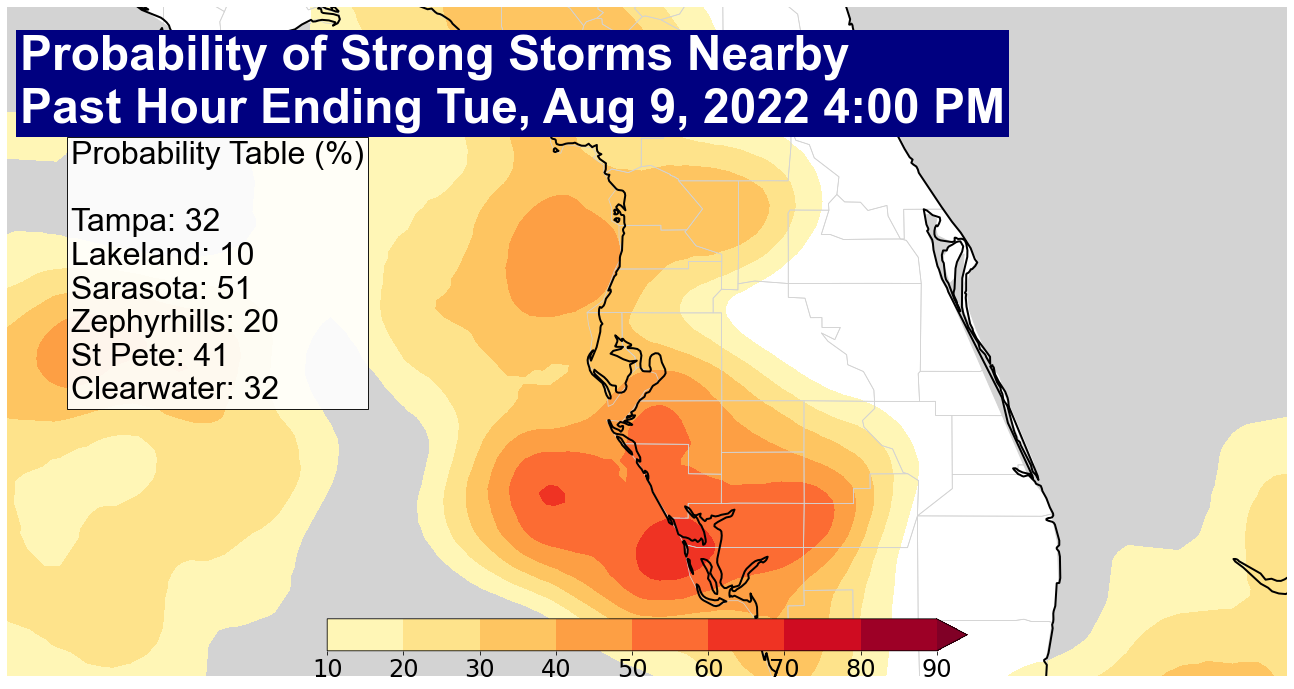

In [34]:
def make_figure():
    new_map = Map('tampa_area')
    new_map.add_counties()
    fig, ax = new_map.make_map()
    return fig, ax

fig, ax = make_figure()

data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.YlOrRd, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Add probability table
probs = ('Probability Table (%)\n\n'
         f'Tampa: {ktpa_prob}\n'
         f'Lakeland: {klal_prob}\n'
         f'Sarasota: {ksrq_prob}\n'
         f'Zephyrhills: {kzph_prob}\n'
         f'St Pete: {kspg_prob}\n'
         f'Clearwater: {kpie_prob}')

ax.text(0.05, 0.80, s=probs, fontsize=32, bbox=dict(facecolor='white', alpha=0.9), 
         transform=ax.transAxes, zorder=4, verticalalignment='top', fontname='Arial')

# Make the axis title
ax.set_title(f'Probability of Strong Storms Nearby \nPast Hour Ending {VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01, zorder=5,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/mxrefd_{fhr}.png', dpi=72)
plt.show()